<a href="https://colab.research.google.com/github/CeaPanochka/NNandMnADIP/blob/main/%D0%A6%D1%8B%D0%B1%D1%83%D0%BB%D0%B0%D0%B5%D0%B2_%D0%A2%D0%B5%D0%BC%D0%B0_%E2%84%967_%D0%98%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D0%B0_%D0%B4%D0%BB%D1%8F_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87_%D1%81%D0%B5%D0%BC%D0%B0%D0%BD%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9_%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%A7%D0%B0%D1%81%D1%82%D1%8C_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Тема №7. Использование автоэнкодера для решения задач семантической сегментации. Часть 1**

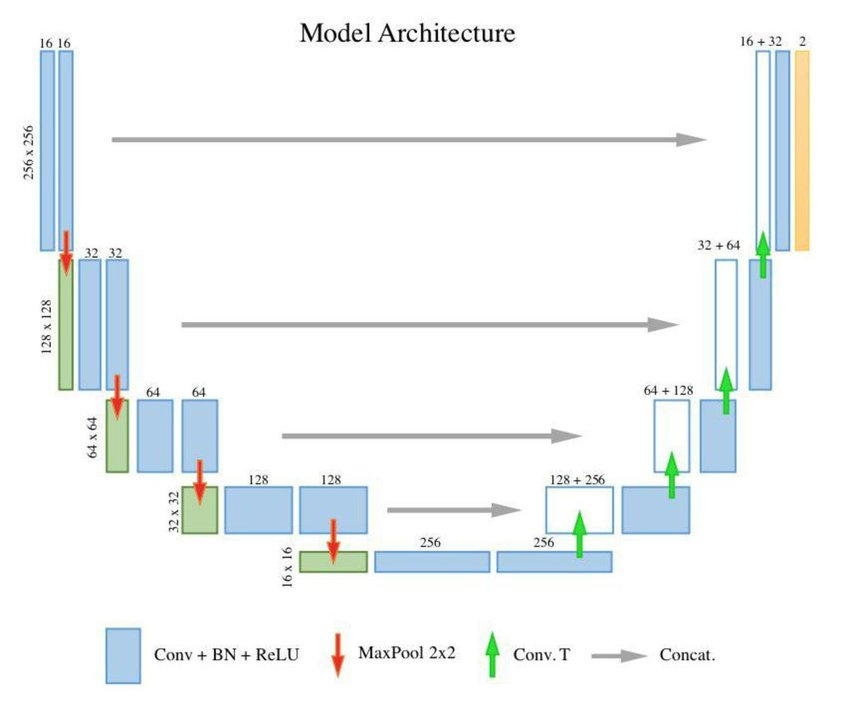

# Этап 1. Выбор и обработка исходных данных. Разделение на обучающую и тестовую выборку

Набор данных:

https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery

Набор данных состоит из аэрофотоснимков Дубая, полученных со спутников MBRSC и аннотированных с помощью семантической сегментации по пикселям на 6 классов. Общий объем набора данных составляет 72 изображения, сгруппированных в 6 больших тайлов. Классами являются:

* Building: #3C1098
* Land (unpaved area): #8429F6
* Road: #6EC1E4
* Vegetation: #FEDD3A
* Water: #E2A929
* Unlabeled: #9B9B9B

Cтруктура снимков:

* Tile 1: 797 x 644 --> 768 x 512 --> 6
* Tile 2: 509 x 544 --> 512 x 256 --> 2
* Tile 3: 682 x 658 --> 512 x 512  --> 4
* Tile 4: 1099 x 846 --> 1024 x 768 --> 12
* Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16
* Tile 6: 859 x 838 --> 768 x 768 --> 9
* Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56
* Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40

Total 9 images in each folder * (145 patches) = 1305

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U -q segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00


In [3]:
#
!pip install patchify

"""!pip install tensorflow==2.9.0
!pip install -U -q segmentation-models"""

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'!pip install tensorflow==2.9.0\n!pip install -U -q segmentation-models'

In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image

tf.compat.v1.enable_eager_execution()
import segmentation_models as sm
from keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Segmentation Models: using `tf.keras` framework.


## 1.1. Обрезка исходных растров на фрагменты (патчи) размером 256x256 с сохранением их в каталог на локальное хранилице

* Считываем изображения из подкаталога 'root_directory'. 

* Поскольку все изображения имеют разный размер, у нас есть 2 варианта: либо изменить размер (resize), либо обрезать.Но некоторые изображения крупномасштабные, а некоторые мелкомасштабные. 

* Изменение размера (resize) изменит размер реальных объектов. Поэтому мы обрезаем их до ближайшего размера, кратного 256, а затем разделим все изображения на участки (патчи) размером 256x256x3.

In [5]:
root_directory = '/content/drive/MyDrive/Semantic segmentation dataset/'

patch_size = 256

In [22]:
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   
        images = os.listdir(path)
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):
                image = cv2.imread(path+"/"+image_name, 1)  
                SIZE_X = (image.shape[1]//patch_size)*patch_size 
                SIZE_Y = (image.shape[0]//patch_size)*patch_size  
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
                image = np.array(image)             
       
                # Разделяем изображение на части
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        single_patch_img = single_patch_img[0] # Убираем лишние ненужные каналы, которые добавляет patchify.                              
                        image_dataset.append(single_patch_img)
          
                        cv2.imwrite(root_directory+"Data/Image/" + image_name + 
                                   "_patch_" + str(i) + str(j) + ".jpg", single_patch_img)

/content/drive/MyDrive/Semantic segmentation dataset/
/content/drive/MyDrive/Semantic segmentation dataset/Tile 8
/content/drive/MyDrive/Semantic segmentation dataset/Tile 8/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 8/images
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/images/image_part_005.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/images/image_part_001.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/images/image_part_007.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/images/image_part_006.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/images/image_part_009.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/images/image_part_008.jpg
Now patchifying image: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/images/image_par

## 1.2. Обрезка исходных масок на фрагменты (патчи) размером 256x256 с сохранением их в каталог на локальное хранилице

In [23]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks': 
        masks = os.listdir(path)  
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):  
               
                mask = cv2.imread(path+"/"+mask_name, 1)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))
                mask = np.array(mask)             
       
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]    
                        mask_dataset.append(single_patch_mask)                           

                        cv2.imwrite(root_directory+"Data/Masks/" + mask_name + 
                                   "_patch_" + str(i) + str(j) + ".png", single_patch_mask)
 


Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/masks/image_part_009.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/masks/image_part_002.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/masks/image_part_006.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/masks/image_part_004.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/masks/image_part_007.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/masks/image_part_001.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/masks/image_part_005.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/masks/image_part_003.png
Now patchifying mask: /content/drive/MyDrive/Semantic segmentation dataset/Tile 8/masks/image_part_008.png
Now patchifying mask: /content/drive/

In [18]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import splitfolders  # or import split_folders

input_folder = root_directory + 'Data/'
output_folder = root_directory + 'ds/'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)

Copying files: 1098 files [00:09, 114.69 files/s]


## 1.3. Проверка патчей масок и исходного растра на соответствие

In [25]:
train_img_dir = r'/content/drive/MyDrive/Semantic segmentation dataset/ds/train/Image/'
train_mask_dir = r'/content/drive/MyDrive/Semantic segmentation dataset/ds/train/Masks/'

In [26]:
img_list = sorted(os.listdir(train_img_dir))
msk_list = sorted(os.listdir(train_mask_dir))

num_images = len(os.listdir(train_img_dir))

print(img_list, msk_list)

['image_part_001.jpg_patch_00.jpg', 'image_part_001.jpg_patch_01.jpg', 'image_part_001.jpg_patch_02.jpg', 'image_part_001.jpg_patch_03.jpg', 'image_part_001.jpg_patch_04.jpg', 'image_part_001.jpg_patch_05.jpg', 'image_part_001.jpg_patch_07.jpg', 'image_part_001.jpg_patch_10.jpg', 'image_part_001.jpg_patch_11.jpg', 'image_part_001.jpg_patch_12.jpg', 'image_part_001.jpg_patch_13.jpg', 'image_part_001.jpg_patch_14.jpg', 'image_part_001.jpg_patch_15.jpg', 'image_part_001.jpg_patch_16.jpg', 'image_part_001.jpg_patch_17.jpg', 'image_part_001.jpg_patch_21.jpg', 'image_part_001.jpg_patch_22.jpg', 'image_part_001.jpg_patch_23.jpg', 'image_part_001.jpg_patch_24.jpg', 'image_part_001.jpg_patch_25.jpg', 'image_part_001.jpg_patch_26.jpg', 'image_part_001.jpg_patch_30.jpg', 'image_part_001.jpg_patch_32.jpg', 'image_part_001.jpg_patch_35.jpg', 'image_part_001.jpg_patch_37.jpg', 'image_part_001.jpg_patch_42.jpg', 'image_part_001.jpg_patch_45.jpg', 'image_part_001.jpg_patch_46.jpg', 'image_part_001.jpg

<Figure size 1200x800 with 0 Axes>

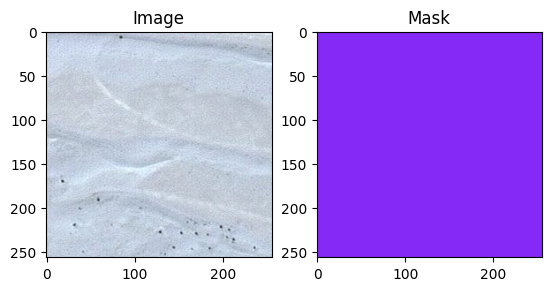

<Figure size 1200x800 with 0 Axes>

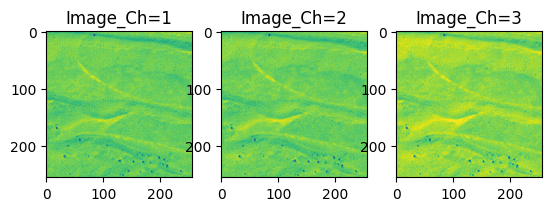

<Figure size 1200x800 with 0 Axes>

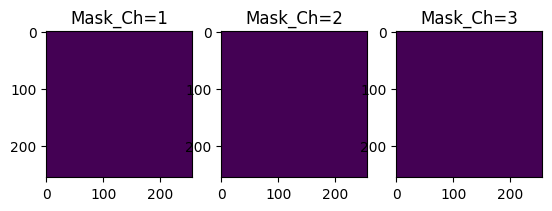

In [27]:
import random

img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num])
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num])
mask_for_plot = cv2.cvtColor(mask_for_plot, cv2.COLOR_BGR2RGB)

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
 
figure, axis = plt.subplots(1, 2)

axis[0].imshow(img_for_plot, cmap=plt.get_cmap('gray'),vmin=0,vmax=100)
axis[0].set_title('Image')

axis[1].imshow(mask_for_plot)
axis[1].set_title('Mask')

plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
 
figure, axis = plt.subplots(1, 3)

axis[0].imshow(img_for_plot[:,:,0])
axis[0].set_title('Image_Ch=1')

axis[1].imshow(img_for_plot[:,:,1])
axis[1].set_title('Image_Ch=2')

axis[2].imshow(img_for_plot[:,:,2])
axis[2].set_title('Image_Ch=3')

# Combine all the operations and display
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
 
figure, axis = plt.subplots(1, 3)

axis[0].imshow(mask_for_plot[:,:,0])
axis[0].set_title("Mask_Ch=1")

axis[1].imshow(mask_for_plot[:,:,1])
axis[1].set_title("Mask_Ch=2")

axis[2].imshow(mask_for_plot[:,:,2])
axis[2].set_title("Mask_Ch=3")

plt.show()


# Этап 2. Предобработка обучающей выборки. Разработка архитектуры модели

In [ ]:

"""
Вычисление RGB из HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152

"""

In [28]:
#Convert HEX to RGB array

Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [29]:
def rgb_to_2D_label(label):
    """
    Замена значений каждого пикселя маски в формате RGB на целое число 
    
    """

    if len(label.shape) == 3: 
        label = label[:,:,:3]
    if len(label.shape) == 4: 
        label = label[:,:,:,:3]

    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5


    if len(label.shape) == 3: 
        label_seg = label_seg[:,:,0]
    if len(label.shape) == 4: 
        label_seg = label_seg[:,:,:,0]
        
    return label_seg

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

def preprocess_data(img, mask, num_class):
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img) 
    mask = rgb_to_2D_label(mask)
    mask = to_categorical(mask, num_class)
      
    return (img, mask)

In [47]:
from keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [48]:
train_img_path = r'/content/drive/MyDrive/Semantic segmentation dataset/ds/train_image/'
train_mask_path = r'/content/drive/MyDrive/Semantic segmentation dataset/ds/train_masks/'

train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=6)

val_img_path = r'/content/drive/MyDrive/Semantic segmentation dataset/ds/val_image/'
val_mask_path = r'/content/drive/MyDrive/Semantic segmentation dataset/ds/val_masks/'
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=6)

In [49]:
seed=24
batch_size= 16
n_classes=6

Found 411 images belonging to 2 classes.
Found 411 images belonging to 2 classes.


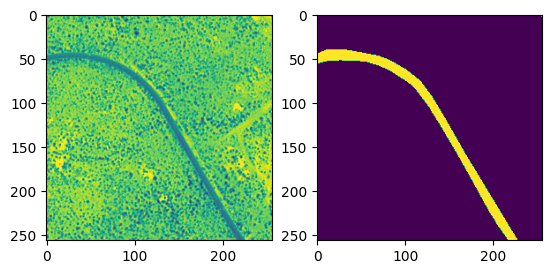

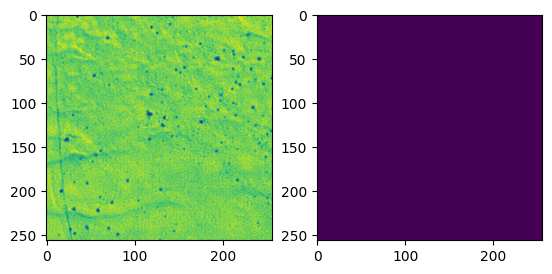

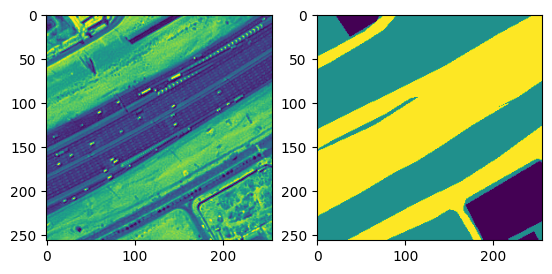

Found 138 images belonging to 2 classes.
Found 138 images belonging to 2 classes.


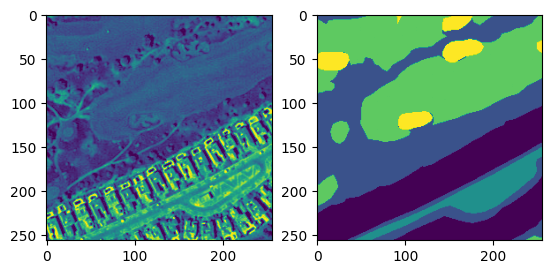

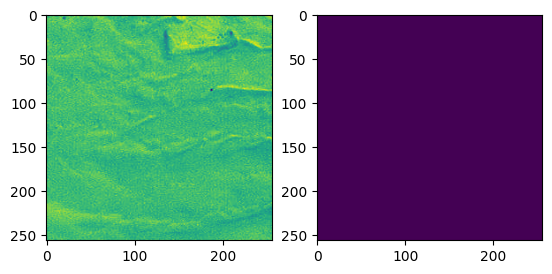

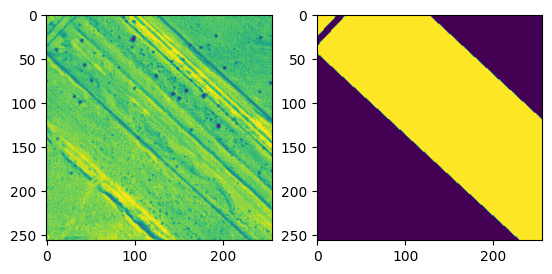

Unique labels in label dataset are:  [1 2]


In [50]:
x, y = train_img_gen.__next__()

for i in range(0,3):
    image = x[i][:,:,0]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i][:,:,0]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

labels, count = np.unique(mask, return_counts=True) #Check for each channel. All chanels are identical

print("Unique labels in label dataset are: ", np.unique(labels))

In [51]:
num_train_imgs = len(os.listdir(r'/content/drive/MyDrive/Semantic segmentation dataset/ds/train_image/train/'))
num_val_images = len(os.listdir(r'/content/drive/MyDrive/Semantic segmentation dataset/ds/val_image/train/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=6

print(num_train_imgs, steps_per_epoch, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(num_train_imgs, num_val_images, steps_per_epoch, val_steps_per_epoch, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

411 25 256 256 3
411 138 25 8 256 256 3


# Этап 3. Обучение модели

In [52]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred): # https://ru.wikipedia.org/wiki/Коэффициент_Жаккара
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

metrics=['accuracy', jacard_coef]

In [53]:
# define model

model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())

94592056/94592056 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

In [54]:
history2=model_resnet_backbone.fit(
          train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

Epoch 1/100
25/25 [==============================] - 69s 1s/step - loss: 1.2635 - accuracy: 0.6187 - jacard_coef: 0.2328 - val_loss: 19.4940 - val_accuracy: 0.5195 - val_jacard_coef: 0.3584
Epoch 2/100
25/25 [==============================] - 17s 702ms/step - loss: 0.6861 - accuracy: 0.7919 - jacard_coef: 0.4657 - val_loss: 4.7010 - val_accuracy: 0.0578 - val_jacard_coef: 0.0436
Epoch 3/100
25/25 [==============================] - 18s 756ms/step - loss: 0.5725 - accuracy: 0.8138 - jacard_coef: 0.5459 - val_loss: 2.9129 - val_accuracy: 0.1180 - val_jacard_coef: 0.0693
Epoch 4/100
25/25 [==============================] - 18s 731ms/step - loss: 0.5409 - accuracy: 0.8203 - jacard_coef: 0.5688 - val_loss: 3.4954 - val_accuracy: 0.0589 - val_jacard_coef: 0.0436
Epoch 5/100
25/25 [==============================] - 17s 695ms/step - loss: 0.5301 - accuracy: 0.8202 - jacard_coef: 0.5849 - val_loss: 1.4821 - val_accuracy: 0.5802 - val_jacard_coef: 0.1576
Epoch 6/100
25/25 [=======================

In [55]:
model_resnet_backbone.save('drive/MyDrive/model/model_resnet50_backbone.h5')

# Этап 4. Визуализация процесса обучения. Оценка точности

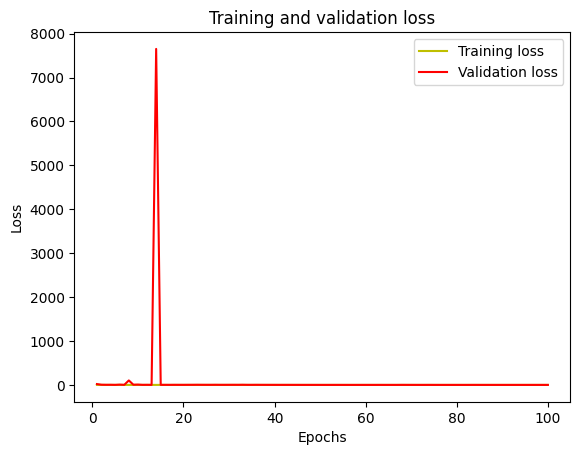

In [57]:
history = history2
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

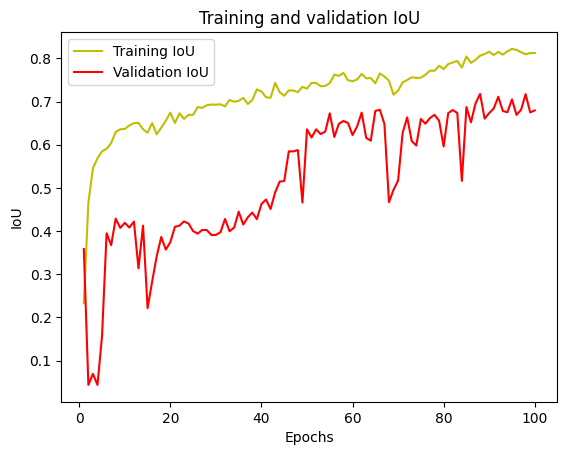

In [58]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

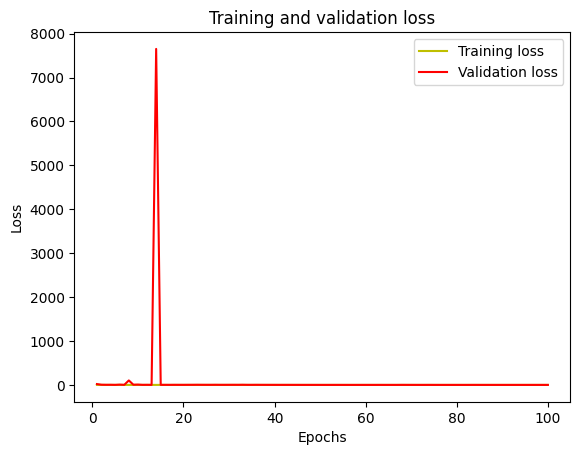

In [59]:
history = history2
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

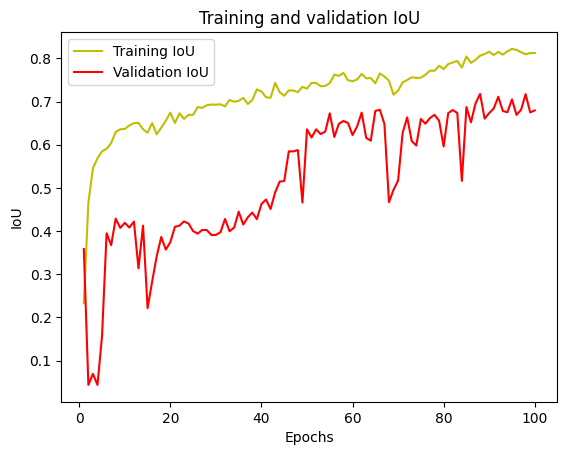

In [60]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [61]:
from keras.models import load_model

model = load_model('drive/MyDrive/model/model_resnet50_backbone.h5', compile=False)

test_image_batch, test_mask_batch = train_img_gen.__next__()
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)
n_classes = 8
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)

print("Mean IoU =", IOU_keras.result().numpy()) # https://megaobuchalka.ru/12/10640.html

1/1 [==============================] - 2s 2s/step
Mean IoU = 0.64456797


<Figure size 1200x800 with 0 Axes>

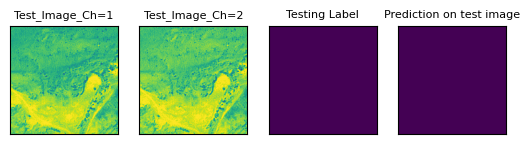

<Figure size 1200x800 with 0 Axes>

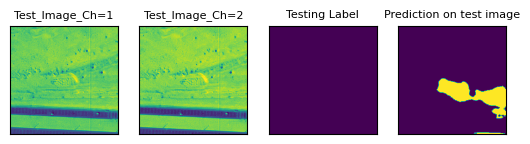

<Figure size 1200x800 with 0 Axes>

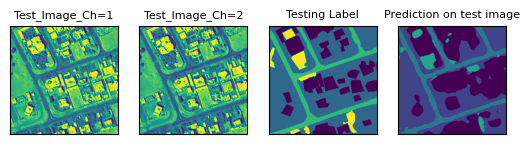

<Figure size 1200x800 with 0 Axes>

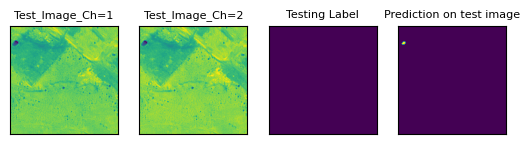

<Figure size 1200x800 with 0 Axes>

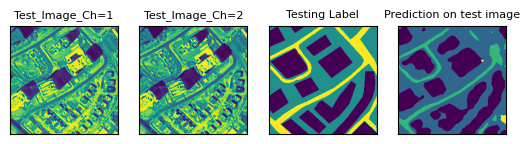

<Figure size 1200x800 with 0 Axes>

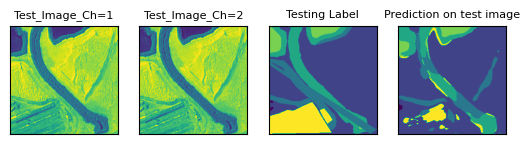

<Figure size 1200x800 with 0 Axes>

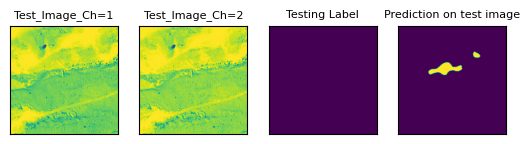

<Figure size 1200x800 with 0 Axes>

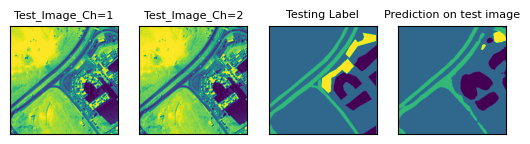

<Figure size 1200x800 with 0 Axes>

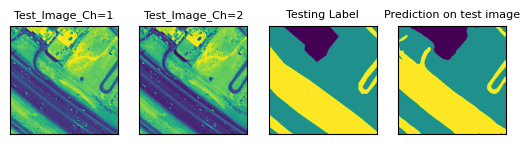

<Figure size 1200x800 with 0 Axes>

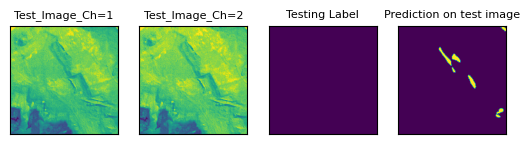

<Figure size 1200x800 with 0 Axes>

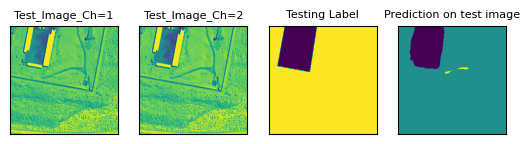

<Figure size 1200x800 with 0 Axes>

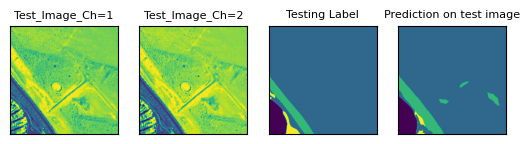

<Figure size 1200x800 with 0 Axes>

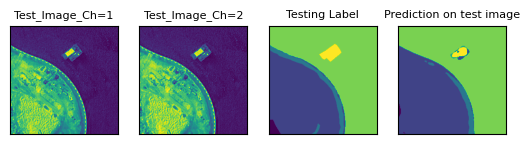

<Figure size 1200x800 with 0 Axes>

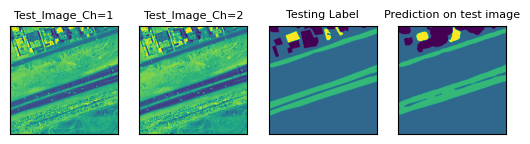

<Figure size 1200x800 with 0 Axes>

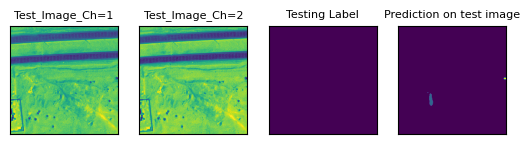

In [62]:
for img_num in range(test_image_batch.shape[0]-1):   

    fig=plt.figure(figsize=(12,8), facecolor='w', edgecolor='k')

    figure, axis = plt.subplots(1, 4)
    fig.tight_layout()

    axis[0].imshow(test_image_batch[img_num][:,:,0])
    axis[0].set_title('Test_Image_Ch=1', fontsize = 8)
    axis[0].axes.xaxis.set_visible(False)
    axis[0].axes.yaxis.set_visible(False)

    axis[1].imshow(test_image_batch[img_num][:,:,1])
    axis[1].set_title('Test_Image_Ch=2', fontsize = 8)
    axis[1].axes.xaxis.set_visible(False)
    axis[1].axes.yaxis.set_visible(False)

    axis[2].imshow(test_mask_batch_argmax[img_num])
    axis[2].set_title("Testing Label", fontsize = 8)
    axis[2].axes.xaxis.set_visible(False)
    axis[2].axes.yaxis.set_visible(False)

    axis[3].imshow(test_pred_batch_argmax[img_num])
    axis[3].set_title("Prediction on test image", fontsize = 8)
    axis[3].axes.xaxis.set_visible(False)
    axis[3].axes.yaxis.set_visible(False)

    plt.show()